<h1><b>Gestational diabetes

<h2><b>1. Data collection

<h3><b> 1.1 Get Microbiom Data

In [ ]:
import os
import datetime
import re
import numpy as np
import pandas as pd
import shap
import optuna
from optuna.visualization import plot_optimization_history
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             r2_score)
from scipy.stats import pearsonr, spearmanr

In [2]:
original_micr_data = pd.read_csv('microbiom_data.csv',
                                 dtype='string', encoding='UTF-8')

In [3]:
# As the warning suggests, the provided table stores mixed data types
type_constrained_micr_data = \
  pd.concat([original_micr_data.iloc[0:413, 0].astype('string'),
  original_micr_data.iloc[0:413, 1:].astype('float')], axis=1)

In [4]:
numerical_micr_data = type_constrained_micr_data.copy()
sample = numerical_micr_data.pop('Sample')
visit = numerical_micr_data.pop('Visit')

In [5]:
# The sample name contains the patient number,
# which will be required to merge the tables
N = sample.apply(lambda row: int(row[0:3]))
N.name = 'N'

In [6]:
# Reading genetic sequences can be very costly in terms of memory consumption
def read_line(file):
    while True:
        line = file.readline()
        if not line:
            break
        yield line

In [7]:
def read_files(files):
    LefSe_otu = []
    for file_name in files:
        try:
            with open(file_name, mode='r', encoding='UTF-8') as file:
                for line in read_line(file):
                    bacteria = re.findall(r'\bOTU_\d+\b', line)
                    if bacteria:
                        LefSe_otu.append(*bacteria)
        except FileNotFoundError:
            print(f"File '{file_name}' not found.")
        except IOError as e:
            print(f"Error reading file '{file_name}': {e}")
    return LefSe_otu

In [8]:
# From the list of representatives of the gut microbiota,
# it was proposed to select for the study the bacteria that showed
# the greatest differences between patient groups as a result of LefSe analysis
LefSe_files = ['LefSe_above_median_BgMax_20_01.tsv',
               'LefSe_above_median_iauc120_20_01.tsv']
selected_otu = np.unique(read_files(LefSe_files))
otu = numerical_micr_data.loc[:, selected_otu]

In [9]:
micr_data = pd.concat([N, visit, otu], axis=1)
micr_data.set_index(['N', 'Visit'], inplace=True)

In [10]:
# The column reflects the period in which the analytical sample was processed
# The filter is designed to cut off a small portion of the data
# that has been corrupted in transit
micr_data = micr_data.loc[(micr_data.index.get_level_values('Visit') == 99) |
                          (micr_data.index.get_level_values('Visit') == 146)]
micr_data = micr_data.reset_index(level='Visit', drop=True)

In [11]:
# Deciphering OTU sequences
microbial_sequences = original_micr_data.iloc[413, 2:]
otu_micr_pairs = dict(zip(microbial_sequences.index,
                          microbial_sequences.to_numpy()))
selected_otu_micr_pairs = \
 {key: otu_micr_pairs[key] for key in micr_data.columns}

In [12]:
micr_data.sort_index()

,OTU_110,OTU_123,OTU_124,OTU_13,OTU_132,OTU_15,OTU_152,OTU_153,OTU_187,OTU_190,...,OTU_587,OTU_609,OTU_677,OTU_68,OTU_712,OTU_76,OTU_77,OTU_79,OTU_84,OTU_98
N,,,,,,,,,,,,,,,,,,,,,
281,0.0,37.0,201.0,49.0,5.0,176.0,24.0,0.0,23.0,0.0,...,0.0,10.0,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0
288,6.0,11.0,87.0,59.0,21.0,54.0,7.0,0.0,0.0,0.0,...,0.0,0.0,7.0,25.0,0.0,0.0,0.0,15.0,8.0,54.0
289,108.0,14.0,0.0,246.0,6.0,104.0,60.0,0.0,0.0,0.0,...,0.0,61.0,0.0,66.0,0.0,26.0,0.0,0.0,58.0,0.0
290,41.0,18.0,0.0,257.0,35.0,295.0,0.0,0.0,0.0,0.0,...,111.0,0.0,0.0,107.0,0.0,622.0,10.0,0.0,0.0,242.0
291,0.0,6.0,95.0,45.0,25.0,163.0,20.0,0.0,0.0,0.0,...,0.0,0.0,0.0,92.0,7.0,245.0,11.0,0.0,0.0,233.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
872,0.0,0.0,0.0,1827.0,35.0,477.0,0.0,0.0,106.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,62.0,205.0,0.0,0.0
873,28.0,52.0,0.0,728.0,52.0,328.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,17.0,0.0,123.0,0.0,156.0,66.0,0.0
874,0.0,22.0,0.0,805.0,48.0,253.0,13.0,0.0,0.0,0.0,...,0.0,0.0,0.0,127.0,0.0,0.0,60.0,67.0,79.0,0.0


<h3><b> 1.2 Get Clinical Data

In [13]:
# Set of clinical parameters proposed by the principal investigator for analysis
clinical_param = ['quality_cgm1', 'CGMS_срок', 'диета_срок',
                  'диета_кал', 'срок_кал1', 'Глюкоза_нт_общая',
                  'прибавка_m1', 'отеки1', 'АД_сист1', 'АД_диаст1',
                  'N_беременностей', 'N_родов', 'N_невынашивание',
                  'N_абортов', 'menses', 'АГ', 'НТГ', 'СД_у_родственников',
                  'КОК', 'курение_до_беременности', 'курение_во_время',
                  'возраст', 'рост', 'вес_до_берем', 'ИМТ', 'фрукты1',
                  'молочное_необезжир1', 'сосиски1', 'бобовые2', 'овощи2',
                  'сосиски2', 'подъем2', 'rs10830963_MTNR1B_N',
                  'глю_нт_V1', 'кетоны_V1', 'HbA1C_V1',
                  'инсулин_V1', 'лептин_V1', 'ФР_V1', 'БОМК_визит1',
                  'Хол_V1', 'ТГ_V1', 'ЛПВП_V1', 'ЛПОНП_V1', 'ЛПНП_V1',
                  'КА_V1', 'АБ_бер_ть']

In [14]:
original_clinical_data = pd.read_csv('clinical_data.csv',
                                     index_col='N',
                                     usecols=['N', *clinical_param],
                                     dtype='float', encoding='UTF-8')
original_clinical_data.index = original_clinical_data.index.astype('int')

In [15]:
additional_clinical_data = \
pd.read_csv('additional_clinical_data.csv',
            index_col='N',usecols=['N', 'CGM_g_age1', 'GM_g_age2',
                                   'diet_before_V1', 'Diet_duration_V1'],
            dtype='float', encoding='UTF-8')
additional_clinical_data.index = additional_clinical_data.index.astype('int')

In [16]:
original_clinical_data = original_clinical_data.join(additional_clinical_data,
                                                     on='N')

In [17]:
# The filter is designed to cut off some patients who carelessly filled out data
clinical_data = original_clinical_data.copy()
clinical_data = clinical_data.loc[clinical_data['quality_cgm1']==0, :]
clinical_data.drop(columns=['quality_cgm1'], axis=1, inplace=True)

In [18]:
# It was suggested that diaries of patients who had taken antibiotics
# less than 4 weeks prior to the study should not be analyzed
clinical_data.drop(labels=[712, 724], axis=0, inplace=True)

In [19]:
# Let's recalculate some biochemical markers as there may have been errors
# or omissions in them
clinical_data['ЛПОНП_V1'] = clinical_data['ТГ_V1'] / 2.18
clinical_data['ЛПНП_V1'] =  (clinical_data['Хол_V1'] -
                             clinical_data['ЛПОНП_V1'] -
                             clinical_data['ЛПВП_V1'])

In [20]:
clinical_data.sort_index()

,CGMS_срок,диета_срок,диета_кал,срок_кал1,Глюкоза_нт_общая,прибавка_m1,отеки1,АД_сист1,АД_диаст1,N_беременностей,...,ТГ_V1,ЛПВП_V1,ЛПОНП_V1,ЛПНП_V1,КА_V1,АБ_бер_ть,CGM_g_age1,GM_g_age2,diet_before_V1,Diet_duration_V1
N,,,,,,,,,,,,,,,,,,,,,
78,30.0,21.0,NaN,NaN,5.26,6.0,0.0,120.0,80.0,2.0,...,1.37,2.71,0.628440,4.591560,1.93,1.0,NaN,NaN,1.0,8.0
166,35.0,33.0,NaN,NaN,4.60,8.0,0.0,110.0,70.0,1.0,...,3.81,2.44,1.747706,5.612294,3.02,0.0,NaN,NaN,0.0,0.0
198,31.0,24.0,NaN,NaN,5.37,3.0,1.0,120.0,80.0,3.0,...,2.21,2.12,1.013761,2.896239,1.84,0.0,NaN,NaN,0.0,0.0
203,NaN,12.0,NaN,NaN,4.90,2.2,0.0,122.0,83.0,2.0,...,2.03,2.54,0.931193,5.278807,2.44,0.0,NaN,NaN,1.0,14.0
212,32.0,NaN,NaN,NaN,4.18,9.0,0.0,110.0,70.0,1.0,...,2.25,2.08,1.032110,4.897890,2.85,0.0,NaN,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,NaN,12.0,NaN,NaN,5.40,0.4,0.0,127.0,90.0,3.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,4.0
901,NaN,8.0,20.0,28.0,5.20,10.0,0.0,100.0,55.0,2.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1.0,19.0
903,NaN,12.0,NaN,NaN,6.90,0.0,0.0,122.0,77.0,3.0,...,2.35,1.41,1.077982,2.342018,2.43,0.0,NaN,NaN,1.0,14.0


<h3><b>1.3 Get monitoring Data

In [21]:
# Set of garbage monitoring parameters (time lags, device info etc.)
garbage_params = ['meal_id', 'ts_meal_start', 'ts_meal_end',
                  'ts_meal_diary', 'meal_shift', 'meal_length',
                  'preg_week', 'meal_type', 'bg_after', 'bg_after_t',
                  'pa_before', 'pa_before_t', 'pa_after', 'prec_meal_shift',
                  'meal_items', 'meal_cats', 'mass_d', 'CGM_range',
                  'CGM_mean', 'CGM_below', 'CGM_above', 'BGb60_to_mean',
                  'BGTrend240', 'BGTrend120', 'BGTrend60', 'BGLag',
                  'BGRise', 'BG65_70', 'BGabove70', 'BG_traffic_light',
                  'uncooked_dishes', 'quality_meal', 'diacompanion',
                  'prediction_function', 'bg_predicted', 'predictionTimeShift',
                  'predictionFunction', 'bg_before30', 'bgBeforeApp',
                  'BGMaxMore', 'count_meals_b12h', 'quality_diary',
                  'quality_cgm1', 'quality_cgm2', 'bg_after_hour',
                  'preg_week_calc', 'Дата_анализ_V1']

In [22]:
# Set of redundant monitoring parameters provided by the principal investigator
redundant_params = ['сладкие_напитки1', 'овощи1', 'хлеб_любой2', 'бобовые1',
                    'спорт2', 'рыба1', 'мясо2', 'хлеб_цельнозерновой_2',
                    'молочное_необезжир2', 'кофе1', 'молочное_обезжир1',
                    'ca', 'хлеб_цельное1', 'мясо1', 'выпечка2', 'сухофрукты1',
                    'ходьба2', 'шоколад2', 'b1', 'пирожные2', 'kar',
                    'спорт1', 'ходьба1', 'пирожные1', 'b2', 'fe', 'выпечка1',
                    'mg', 'сухофрукы2', 'water', 'ne', 'zola', 're', 'фрукты2',
                    'ok', 'хлеб_любой1', 'рыба2', 'овощи2_сырые', 'k', 'соусы2',
                    'подъем1', 'сладкие_напитки2', 'алкоголь1',
                    'молочное_обезжир2', 'соусы1', 'овощи1_сырые', 'c',
                    'алкоголь2', 'a', 'кофе2', 'срок_анализы_V1', 'шоколад1',
                    'p', 'na']

In [23]:
# Continuous glucose monitoring parameters
# (clearly very important, but interfere with this analysis)
cgms = ['CGM_range', 'CGM_mean', 'CGM_below', 'CGM_above', 'BGb60_to_mean',
        'iAUCb240', 'iAUCb120', 'iAUCb60', 'BGRiseb240', 'BGRiseb120',
        'BGRiseb60', 'BGTrend240', 'BGTrend120', 'BGTrend60', 'BGb240',
        'BGb120', 'BGb60', 'BGb50', 'BGb40', 'BGb30', 'BGb25', 'BGb20',
        'BGb15', 'BGb10', 'BGb5', 'BGLag', 'BGRise','BG65_70',
        'BGabove70', 'BG_traffic_light']

In [24]:
original_monitoring_data = \
pd.read_csv('monitoring_data.csv', index_col='N',
            dtype='string', encoding='UTF-8')

In [25]:
for column in original_monitoring_data.columns:
    try:
        original_monitoring_data[column] = \
          original_monitoring_data[column].astype('float')
    except:
        pass
original_monitoring_data.index = \
  pd.to_numeric(original_monitoring_data.index, errors='raise')

In [26]:
# Remove all unnecessary items
pattern = f'Unnamed|meal_items|meal_mass|meal_time|without'
redundant_params.extend(original_monitoring_data.filter(regex=pattern,
                                                        axis=1).columns)
monitoring_data = original_monitoring_data.copy()
monitoring_data = \
  monitoring_data.loc[:, ~monitoring_data.columns.isin([*garbage_params,
                                                        *redundant_params,
                                                        *cgms])]

In [27]:
# Exclude patients who were taking insulin
insulin_features = ['i_before', 'i_before_t', 'i_type']
monitoring_data = monitoring_data[
    (monitoring_data['project'] == 3) &
    (monitoring_data['i_before'].isna())
]
monitoring_data.drop(labels=['project', *insulin_features],
                     axis=1, inplace=True)

In [28]:
# During the analysis of the literature, the most
# significant parameters for forecasting were identified
targets = ['BG30', 'BG60', 'BG90', 'BG120', 'BGMax',
           'AUC60', 'AUC120', 'iAUC60', 'iAUC120']
factors = ['BG0', 'gi', 'gl', 'carbo', 'prot', 'fat']
monitoring_data.dropna(subset=[*factors, *targets], inplace=True)

In [29]:
monitoring_data.sort_index()

,n_cgm,meal_type_n,gi,gl,carbo,prot,fat,kcal,mds,kr,...,Глюкоза_нт_общая,Группа,Срок_анализ_V1,фрукты1,молочное_необезжир1,сосиски1,бобовые2,овощи2,сосиски2,подъем2
N,,,,,,,,,,,,,,,,,,,,,
77.0,1.0,2.0,14.7,55.2,45.00,19.90,42.20,642.30,8.00,36.89,...,4.40,1.0,25.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0
77.0,1.0,3.0,18.6,19.4,29.50,47.90,12.50,432.10,22.24,7.19,...,4.40,1.0,25.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0
77.0,1.0,1.0,5.3,18.4,29.40,40.60,14.00,414.70,20.58,8.79,...,4.40,1.0,25.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0
77.0,1.0,2.0,51.3,85.2,75.30,24.20,31.90,691.00,8.45,66.95,...,4.40,1.0,25.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0
77.0,1.0,3.0,50.7,49.3,47.60,10.20,19.80,415.00,23.80,23.80,...,4.40,1.0,25.0,2.0,3.0,1.0,1.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017.0,1.0,4.0,54.9,36.6,23.53,11.26,8.76,220.30,0.00,0.11,...,4.83,6.0,31.0,1.0,2.0,3.0,2.0,3.0,3.0,2.0
1017.0,1.0,4.0,45.0,41.9,31.68,1.65,18.70,302.50,0.00,1.65,...,4.83,6.0,31.0,1.0,2.0,3.0,2.0,3.0,3.0,2.0
1017.0,1.0,1.0,55.0,54.6,47.85,25.29,12.56,400.61,0.00,0.12,...,4.83,6.0,31.0,1.0,2.0,3.0,2.0,3.0,3.0,2.0


<h3><b>1.4 Conjugate tables

In [30]:
data = clinical_data.merge(micr_data, on='N', how='inner')

In [31]:
data = monitoring_data.merge(data, on='N', how='inner',
                             suffixes=('_monitoring', '_clinical'))

In [32]:
redundant_params = data.filter(regex='_monitoring').columns
data.drop(labels=redundant_params, axis=1, inplace=True)
data.rename(columns=lambda x: re.sub(r'_clinical$', '', x), inplace=True)

In [33]:
data['CGMS_срок'] = np.where(data['n_cgm'] == 1,
                             data['CGM_g_age1'],
                             data['GM_g_age2'])
data.drop(labels=['CGM_g_age1', 'GM_g_age2', 'n_cgm'], axis=1, inplace=True)

In [34]:
data.sort_index(inplace=True)
data

,meal_type_n,gi,gl,carbo,prot,fat,kcal,mds,kr,pv,...,OTU_587,OTU_609,OTU_677,OTU_68,OTU_712,OTU_76,OTU_77,OTU_79,OTU_84,OTU_98
N,,,,,,,,,,,,,,,,,,,,,
281.0,4.0,38.5,3.7,9.6,0.8,0.3,49.0,9.50,0.10,1.50,...,0.0,10.0,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0
281.0,4.0,1.5,3.7,10.3,2.9,0.8,71.5,27.30,0.10,1.70,...,0.0,10.0,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0
281.0,3.0,16.4,26.4,36.4,13.6,43.1,593.7,18.11,18.30,9.64,...,0.0,10.0,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0
281.0,4.0,45.0,7.4,18.2,19.2,4.0,200.0,34.82,0.62,4.06,...,0.0,10.0,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0
281.0,4.0,22.2,14.7,20.9,1.8,0.7,102.0,19.53,1.38,4.86,...,0.0,10.0,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873.0,4.0,16.0,12.8,20.9,9.3,3.3,161.8,20.93,0.00,0.93,...,0.0,0.0,0.0,17.0,0.0,123.0,0.0,156.0,66.0,0.0
873.0,2.0,27.0,22.6,20.0,8.7,11.0,216.8,5.33,14.62,2.42,...,0.0,0.0,0.0,17.0,0.0,123.0,0.0,156.0,66.0,0.0
873.0,4.0,51.6,22.8,19.5,5.9,14.9,228.6,16.24,1.89,3.60,...,0.0,0.0,0.0,17.0,0.0,123.0,0.0,156.0,66.0,0.0


<h2><b>2. Exploratory data analysis

<h3><b>2.1 Exploring hidden patters and feature engineering

In [35]:
# Lets examine the data characterizing the patients
# included in the preliminary dataset
N = data.index.unique()
noutof_clinical_data = clinical_data[clinical_data.index.isin(N)]
noutof_clinical_data.describe()

,CGMS_срок,диета_срок,диета_кал,срок_кал1,Глюкоза_нт_общая,прибавка_m1,отеки1,АД_сист1,АД_диаст1,N_беременностей,...,ТГ_V1,ЛПВП_V1,ЛПОНП_V1,ЛПНП_V1,КА_V1,АБ_бер_ть,CGM_g_age1,GM_g_age2,diet_before_V1,Diet_duration_V1
count,12.000000,69.000000,58.000000,82.000000,97.000000,95.000000,97.00000,97.000000,97.000000,97.000000,...,96.000000,96.000000,96.000000,96.000000,63.000000,95.000000,97.000000,16.000000,97.000000,97.000000
mean,30.000000,22.391304,4.862069,27.560976,4.917423,6.656842,0.14433,119.082474,74.835052,2.144330,...,1.960729,1.968438,0.899417,3.489333,2.172222,0.105263,30.113402,34.625000,0.536082,2.979381
std,3.592922,6.761085,5.410997,3.399701,0.590796,3.873963,0.35325,11.542196,9.573923,1.274671,...,0.748446,0.414148,0.343324,1.088565,0.765191,0.308520,3.363023,2.680174,0.501287,5.004122
min,22.000000,3.000000,0.000000,14.000000,3.200000,0.000000,0.00000,90.000000,60.000000,1.000000,...,0.730000,1.180000,0.334862,1.730459,0.820000,0.000000,14.000000,25.000000,0.000000,0.000000
25%,28.750000,17.000000,2.000000,26.000000,4.500000,4.250000,0.00000,110.000000,70.000000,1.000000,...,1.400000,1.650000,0.642202,2.707408,1.705000,0.000000,28.000000,35.000000,0.000000,0.000000
50%,30.000000,25.000000,3.000000,28.000000,5.030000,7.000000,0.00000,120.000000,75.000000,2.000000,...,1.930000,1.945000,0.885321,3.383394,2.110000,0.000000,31.000000,35.000000,1.000000,1.000000
75%,31.500000,26.000000,5.000000,30.000000,5.300000,9.500000,0.00000,125.000000,80.000000,3.000000,...,2.322500,2.275000,1.065367,4.194450,2.555000,0.000000,33.000000,36.000000,1.000000,4.000000
max,36.000000,35.000000,27.000000,32.000000,6.500000,15.000000,1.00000,150.000000,120.000000,7.000000,...,4.350000,3.440000,1.995413,7.918165,4.890000,1.000000,36.000000,37.000000,1.000000,26.000000


In [36]:
px.imshow(noutof_clinical_data.corr())

### Inference:
1) In general, the correlation between columns is low, with individual yellow dots corresponding to columns that store test dates in weeks of pregnancy.
This probably indicates that most people had their tests either on the same day or with a small gap.
2) The small cluster at the top of the heat map reflects correlations between number of births, abortions, number of children successfully carried, etc., which is not questionable and looks logical.
3) The large cluster of fiches at the bottom of the diagonal line indicates strong correlations between biochemical parameters taken, as already established in (1), at the same week of gestation.
4) Associations between systolic and diastolic blood pressure, pre-pregnancy weight and BMI taken at the time of enrollment are also seen.
5) White dots on the graph: НТГ - does not contain missing values, but its variability is almost 0

### Conclusions
Let's remove these columns

In [37]:
data.drop(labels='НТГ', axis=1, inplace=True)

In [38]:
px.box(pd.concat([noutof_clinical_data['Глюкоза_нт_общая'],
                  data['BGMax'].groupby('N').median(),
                  data['AUC120'].groupby('N').median(),
                  noutof_clinical_data['СД_у_родственников']],
                  axis=1), color='СД_у_родственников',
       notched=True, points='all')

### Inference:
In those patients who have relatives with type 1 or type 2 diabetes (unclear), fasting glucose levels (Глюкоза_нт_общая) are higher and the median peak postprandial glucose level (BGMax) is also noticeably higher, however, the total area under the glycemic curve (AUC120) is rather the same. The latter fact suggests that higher peak glucose levels after meals are followed by a sharp drop in glycemic levels ((BGMax-BG120)/BG120). An alternative cause may be lower premeal glucose values BG0 (not to be confused with fasting glucose values - Глюкоза_нт_общая). You may also notice some asymmetry in the data. There are slightly more patients who have no relatives with diabetes.

In [39]:
px.box(pd.concat([data['BG0'].groupby('N').median(),
                  noutof_clinical_data['СД_у_родственников']],
                  axis=1),
       color='СД_у_родственников', notched=True, points='all')

In [40]:
numerator = (data['BGMax'].groupby('N').median()-
             data['BG120'].groupby('N').median())
denominator = data['BG120'].groupby('N').median()
bg_drop_rate = numerator / denominator
px.box(pd.concat([bg_drop_rate, noutof_clinical_data['СД_у_родственников']],
                  axis=1),
       color='СД_у_родственников', notched=True, points='all')

### Conclusion
Let's add the ratio of the magnitude of the drop in glucose level to the baseline value after 120 minutes as another target variable. Additionally, it may be useful to know the median of this value over previous meals to predict AUC120, but this requires more careful work, selection of the correct time window and consultations with a domain specialist about the nature of this effect.

In [41]:
data['BG_drop_rate'] = (data['BGMax'] - data['BG120']) / data['BG120']

In [42]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df = pd.concat([data['gl'], data['carbo'],
                data['gi'], data['meal_type_n']], axis=1)
df[['gl', 'carbo', 'gi']] = scaler.fit_transform(df[['gl', 'carbo', 'gi']])
px.scatter_ternary(df, a='gl', b='carbo', c='gi', color='meal_type_n')

In [43]:
df = pd.concat([data['carbo'], data['prot'],
                 data['fat'], data['meal_type_n']], axis=1)
df[['carbo', 'prot', 'fat']] = scaler.fit_transform(df[['carbo',
                                                        'prot',
                                                        'fat']])
px.scatter_ternary(df, a='carbo', b='prot', c='fat', color='meal_type_n')

### Inference
The graph shows that meal_type_n = 4, which corresponds to snacks associated with a high glycemic index (gi) and carbohydrates (carbo). It is logical to assume that during snacks, patients used sugar-containing products as part of their meals. It might also make sense to break down meal times into more categories and see if we can visually separate the classes on a ternary plot.

In [44]:
nbins = 4
fig = make_subplots(rows=1, cols=nbins-1,
                    specs=[[{'type': 'ternary'} for n in range(nbins-1)]],
                    subplot_titles=[f'nbins = {n+2}' for n in range(nbins-1)],
                    horizontal_spacing=.2)

for n in range(2, nbins+1):
    binned_daytime = pd.cut(data['daytime'], bins=n)
    df = pd.concat([data['carbo'], data['prot'], data['fat'], binned_daytime],
                   axis=1)
    df[['carbo', 'prot', 'fat']] = scaler.fit_transform(df[['carbo',
                                                            'prot',
                                                            'fat']])
    daytimes = df['daytime'].unique()
    encoder = LabelEncoder()
    colors = encoder.fit_transform(daytimes)
    for i, daytime in enumerate(daytimes):
        mask = df['daytime'] == daytime
        fig.add_trace(go.Scatterternary(a=df.loc[mask, 'carbo'],
                                        b=df.loc[mask, 'prot'],
                                        c=df.loc[mask, 'fat'],
                                        mode='markers',
                                        name=str(daytime),
                                        marker={'color': colors[i]}),
                                        row=1, col=n-1)
    fig.update_ternaries(aaxis_title='Carbo', baxis_title='Prot',
                         caxis_title='Fat', row=1, col=n-1)
title = 'Changes in the nutritional composition of food throughout the day'
fig.update_layout(title=title, legend_title='Time intervals')

### Conclusion
1) It can be seen that there is a slight bias towards saturated fatty foods in the period before 11am. After consultation with a nutritionist and diabetologist, it was learned that the postprandial glycemic response does tend to be sharper in the morning. A new binary variable should be added, 0 - eating before 11am, 1 - after 11am.
2) Snacking is associated with a higher glycemic index of the product, but surprisingly, the glycemic load and number of carbohydrates in the product, is relatively low. After consultation with a nutritionist, it became clear that these features were related to the carbohydrate-free diet the patients were on during the monitoring period.

In [45]:
data['daytimeb11'] = (data['daytime'] < 11).astype('int')

<h3><b>2.2 Replacing missing values

In [46]:
nans_percentage = data.isna().mean()
any_na = nans_percentage[nans_percentage > 0]
any_na.index

Index(['prec_meal_gi', 'prec_meal_gl', 'prec_meal_carbo', 'prec_meal_prot',
       'prec_meal_fat', 'prec_meal_pv', 'bgBefore_glu', 'через1час_тест',
       'через2часа_тест', 'ИЦН', 'диета_срок', 'диета_кал', 'срок_кал1',
       'прибавка_m1', 'rs10830963_MTNR1B_N', 'ФР_V1', 'Хол_V1', 'ТГ_V1',
       'ЛПВП_V1', 'ЛПОНП_V1', 'ЛПНП_V1', 'КА_V1', 'АБ_бер_ть'],
      dtype='object')

### Inference
1) All prognostic parameters with the prefix "prec" refer to previous meals, missing values are equivalent to zero.
2) All monitoring parameters are marked with time stamps from 0 to 120 and are critical for prediction. Omissions in them are rare, such lines should be deleted.
3) The bgBefore_glu parameter corresponds to BG0, however, they are taken by different devices. To increase the consistency of the dataset, it is better to leave one of the columns with fewer skips, i.e. BG0.
4) Gaps in the other parameters should not be evaluated in the same way because they are not unique values. They are patient parameters and are repeated many times in each row of the dataset. We should cast the dataset to 1 line per 1 patient and count the number of omissions, relative to the number of patients.

### Conclusions

In [47]:
prec_meal_params = any_na.filter(regex='prec_').index
data[prec_meal_params] = data[prec_meal_params].fillna(value=0)

In [48]:
matches = re.findall(r"iAUCb\d+|BGRiseb\d+|BGb\d+",
                     ', '.join(any_na.index.to_list()))
data.dropna(subset=matches, inplace=True)

In [49]:
data.drop('bgBefore_glu', axis=1, inplace=True)

In [50]:
row_per_patient = data.groupby('N').mean()
nans_percentage = row_per_patient.isna().mean()
any_na = nans_percentage[nans_percentage > 0]
any_na

через1час_тест         0.278351
через2часа_тест        0.268041
ИЦН                    0.041237
диета_срок             0.288660
диета_кал              0.402062
срок_кал1              0.154639
прибавка_m1            0.020619
rs10830963_MTNR1B_N    0.072165
ФР_V1                  0.010309
Хол_V1                 0.010309
ТГ_V1                  0.010309
ЛПВП_V1                0.010309
ЛПОНП_V1               0.010309
ЛПНП_V1                0.010309
КА_V1                  0.350515
АБ_бер_ть              0.020619
dtype: float64

### Inference
About half of all the remaining parameters have more than 20% omissions, it would be best to just delete them. The remaining gaps are categorized as MAR (Missing at Random). It is not entirely clear whether to use MICE imputation or to leave them as is and use models based on decision trees. Nevertheless, based on the fact that LSTM models showed the best results in predicting glycemia levels from continuous monitoring data, the possibility of using deep neural networks should be considered and, therefore, the gaps should be filled in by MICE (Iterative Imputer) or KNN Imputer methods.

In [51]:
data.drop(labels=nans_percentage[nans_percentage > 0.2].index, axis=1, inplace=True)

In [52]:
data.index.value_counts()

N
832.0    71
693.0    68
699.0    65
837.0    61
718.0    60
         ..
779.0     8
563.0     8
744.0     8
668.0     1
704.0     1
Name: count, Length: 97, dtype: Int64

In [53]:
data.drop(labels=[668, 704], inplace=True)

<h3><b>2.3 Data description

In [54]:
with open('general_dataset_description.txt',
          'w', encoding='UTF-8') as file:

    file.write(f'Total number of unique patients: {len(data.index.unique())}\n')
    file.write(f'Total number of rows: {data.shape[0]}\n\n')

    file.write(f'FEATURES ({len(data.columns)})\n\n')
    file.write('\n'.join(data.columns) + '\n\n')

    file.write('OTU DECIPHER\n\n')
    for key, value in selected_otu_micr_pairs.items():
        file.write(f'{key}: {value}\n')

<h3><b>2.4 Export

In [55]:
data = np.round(data, 4)
data

,meal_type_n,gi,gl,carbo,prot,fat,kcal,mds,kr,pv,...,OTU_677,OTU_68,OTU_712,OTU_76,OTU_77,OTU_79,OTU_84,OTU_98,BG_drop_rate,daytimeb11
N,,,,,,,,,,,,,,,,,,,,,
281.0,4.0,38.5,3.7,9.6,0.8,0.3,49.0,9.50,0.10,1.50,...,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0,0.2045,0
281.0,4.0,1.5,3.7,10.3,2.9,0.8,71.5,27.30,0.10,1.70,...,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0000,0
281.0,3.0,16.4,26.4,36.4,13.6,43.1,593.7,18.11,18.30,9.64,...,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0392,0
281.0,4.0,45.0,7.4,18.2,19.2,4.0,200.0,34.82,0.62,4.06,...,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0784,0
281.0,4.0,22.2,14.7,20.9,1.8,0.7,102.0,19.53,1.38,4.86,...,0.0,19.0,0.0,0.0,0.0,0.0,27.0,43.0,0.0250,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873.0,4.0,16.0,12.8,20.9,9.3,3.3,161.8,20.93,0.00,0.93,...,0.0,17.0,0.0,123.0,0.0,156.0,66.0,0.0,0.1373,0
873.0,2.0,27.0,22.6,20.0,8.7,11.0,216.8,5.33,14.62,2.42,...,0.0,17.0,0.0,123.0,0.0,156.0,66.0,0.0,0.0179,0
873.0,4.0,51.6,22.8,19.5,5.9,14.9,228.6,16.24,1.89,3.60,...,0.0,17.0,0.0,123.0,0.0,156.0,66.0,0.0,0.1961,0


In [56]:
data.to_pickle('data.pkl')

In [57]:
data.to_csv('data.csv', encoding='UTF-8')

<h2><b>3. Model pipeline development

Prediction of continuous values, which include parameters characterizing the postprandial glycemic response, refers to the solution of the regression problem. The most widely used metrics for assessing the quality of regression are MAE and MSE. However, in the course of literature analysis of the problem, it was found that RMSE, R, R2, MSLE, MAPE and some others are often used to assess the quality of glucose prediction models (https://ieeexplore.ieee.org/document/9281297)

In [58]:
# Let's redefine the target variables taking into account the EDA results
general_targets = [*targets, 'BG_drop_rate']
selected_targets = ['BGMax', 'iAUC120', 'AUC60']

<h4><b>3.1 Experiment tracking

In [59]:
# Setup control over randomnes
seed = 0
rng = np.random.RandomState(0)

In [60]:
history = dict()

<h4><b>3.2 Data transformation

In [61]:
# Split the dataset by patient number
def spliter(N: list[int], seed: int = None):
    n_train, n_test = train_test_split(N, test_size=.25,
                                       shuffle=True,
                                       random_state=seed)
    return n_train, n_test

In [62]:
# Data transformation for training
def transform(data: pd.DataFrame, target: str, general_targets: list[str], otus: list[str] = None, exclude_otus=False):
    n_train, n_test = spliter(data.index.unique().tolist(), seed=seed)
    if exclude_otus:
        data = data.drop(columns=otus, axis=1)
    features = data.columns.difference(general_targets, sort=False).tolist()
    datasets = {name: data.loc[data.index.isin(n),:].copy() for name, n in zip(['train', 'test'], [n_train, n_test])}
    for name, dataset in datasets.items():
        y = dataset.pop(target)
        dataset.drop(columns=[col for col in general_targets if col != target], axis=1, inplace=True)
        X = dataset
        datasets[name] = (X.to_numpy(), y.to_numpy())
    return ((datasets['train'], datasets['test']),
            (n_train, n_test), features)

<h3><b>3.3 Baseline model

In [63]:
history['baseline_model'] = {}
for target in selected_targets:
    ((train, test), (n_train, n_test), features) = \
      transform(data, target, general_targets)
    model = lambda y_train, y_test: [np.mean(y_train)]*len(y_test)
    y_pred = model(train[1], test[1])
    history['baseline_model'][target] = \
      {'Data': {'train': (train[0], train[1]),
                'test': (test[0], test[1])},
       'Features': features,
       'Patients': {'train': n_train,
                    'test': n_test},
       'Model': model,
       'Metrics': {'mae': mean_absolute_error(test[1], y_pred),
                   'mse': mean_squared_error(test[1], y_pred),
                   'rmse': mean_squared_error(test[1], y_pred, squared=False),
                   'r2': r2_score(test[1], y_pred)}
      }

<h3><b>3.4 Extreem Gradient Boosting Regression Tree with Optuna

<h4><b>3.4.1 Optuna configuration

In [64]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [65]:
def objective(trial, train):
    params = {
        'objective': 'reg:squarederror',
        'device': 'gpu',
        'eta': trial.suggest_float('eta', 1e-3, 0.3, log=True),
        'gamma': trial.suggest_int('gamma', 0, 5),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'seed': 0
    }
    cv_results = \
        xgb.cv(params=params, dtrain=train,
               num_boost_round=trial.suggest_int('num_boost_round',
                                                 100, 800, step=25),
               metrics='rmse', seed=0)
    cv_mean = cv_results['test-rmse-mean'].iloc[-1]
    return cv_mean

In [66]:
def run_the_study(train):
    study = \
        optuna.create_study(direction='minimize',
                            sampler=optuna.samplers.TPESampler(seed=seed),
                            pruner=optuna.pruners.SuccessiveHalvingPruner(),
                            study_name=target)
    study.optimize(lambda trial: objective(trial, train),
                   n_trials=100,
                   show_progress_bar=True)
    return study

<h4><b>3.4.2 Run studies

In [67]:
exclude_experimental = [True, False]
for flag in exclude_experimental:
  history['Without OTUs' if flag else 'With OTUs'] = {}
  for target in selected_targets:

        ((train, test), (n_train, n_test), features) = \
          transform(data, target, general_targets,
                    otus=selected_otu, exclude_otus=flag)
        
        study = run_the_study(xgb.DMatrix(train[0], label=train[1]))
        fig = plot_optimization_history(study)
        fig.show()
        
        params = study.best_trial.params
        n_estimators = params.pop('num_boost_round')
        
        model = xgb.train(params,
                          dtrain=xgb.DMatrix(train[0], label=train[1]),
                          num_boost_round=n_estimators)
        y_pred = model.predict(xgb.DMatrix(test[0], label=test[1]))

        history['Without OTUs' if flag else 'With OTUs'][target] = \
        {'Data': {'train': (train[0], train[1]),
                  'test': (test[0], test[1])},
         'Features': features,
         'Patients': {'train': n_train,
                      'test': n_test},
         'Model': {'file': model,
                   'parameters': study.best_trial.params},
         'Metrics': {'mae': mean_absolute_error(test[1], y_pred),
                     'mse': mean_squared_error(test[1], y_pred),
                     'rmse': mean_squared_error(test[1], y_pred,
                                                squared=False),
                     'pearson': pearsonr(test[1], y_pred)[0],
                     'spearman': spearmanr(test[1], y_pred)[0],
                     'r2': r2_score(test[1], y_pred)}}

Best trial: 86. Best value: 0.642263: 100%|██████████| 100/100 [05:29<00:00,  3.30s/it]


Best trial: 56. Best value: 0.475411: 100%|██████████| 100/100 [05:21<00:00,  3.22s/it]


Best trial: 87. Best value: 0.406587: 100%|██████████| 100/100 [05:30<00:00,  3.31s/it]


Best trial: 93. Best value: 0.639117: 100%|██████████| 100/100 [03:53<00:00,  2.34s/it]


Best trial: 69. Best value: 0.469308: 100%|██████████| 100/100 [05:46<00:00,  3.46s/it]


Best trial: 92. Best value: 0.402829: 100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


<h3><b>4 Interpretation and recording of results

In [68]:
now = datetime.datetime.now()
formatted_time = now.strftime("%d-%m-%Y %H-%M-%S")
path = f'results {formatted_time}'
os.makedirs(path)

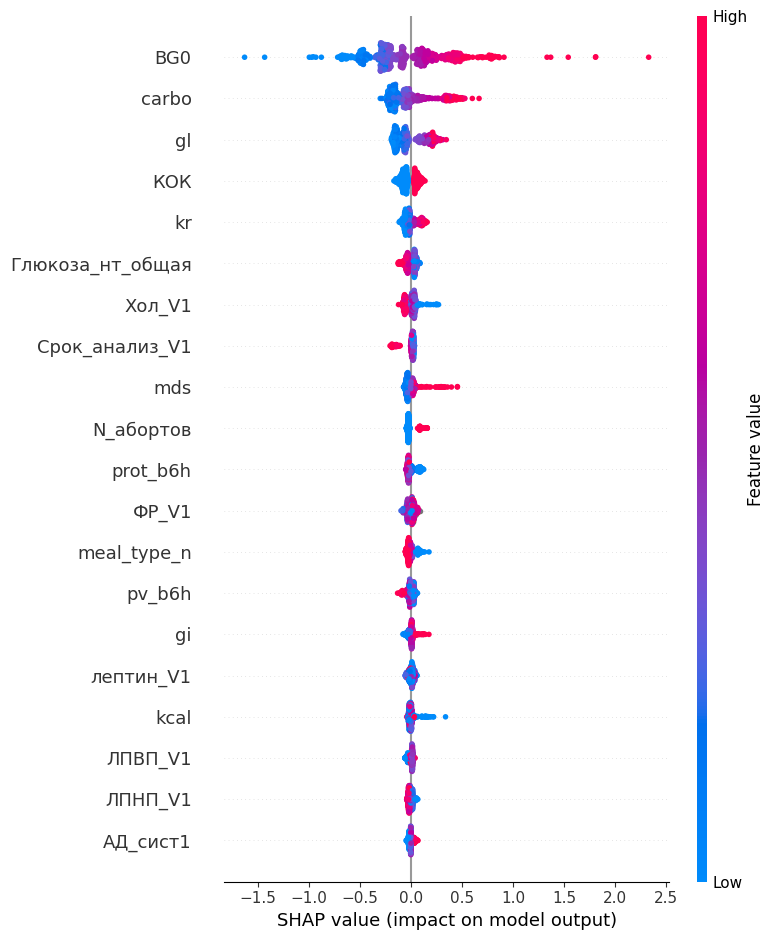

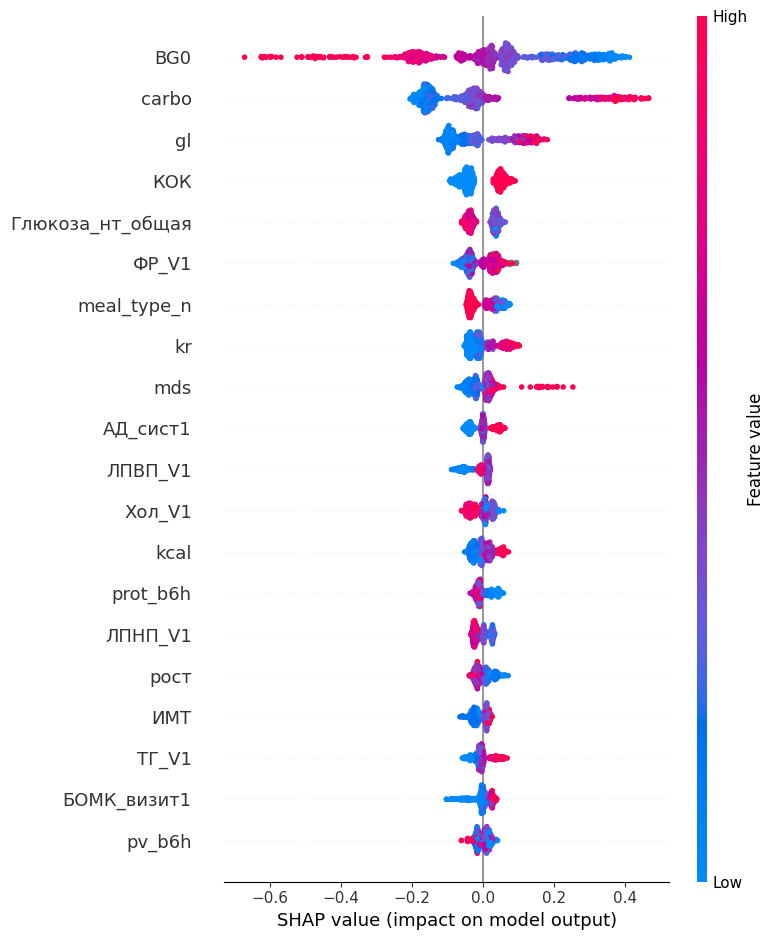

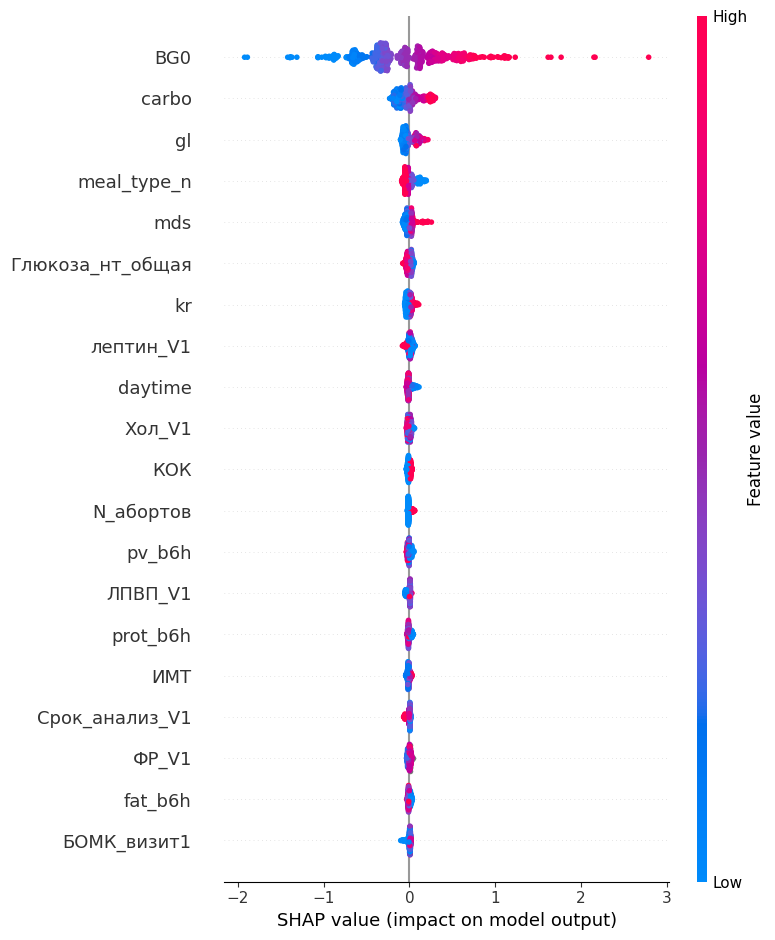

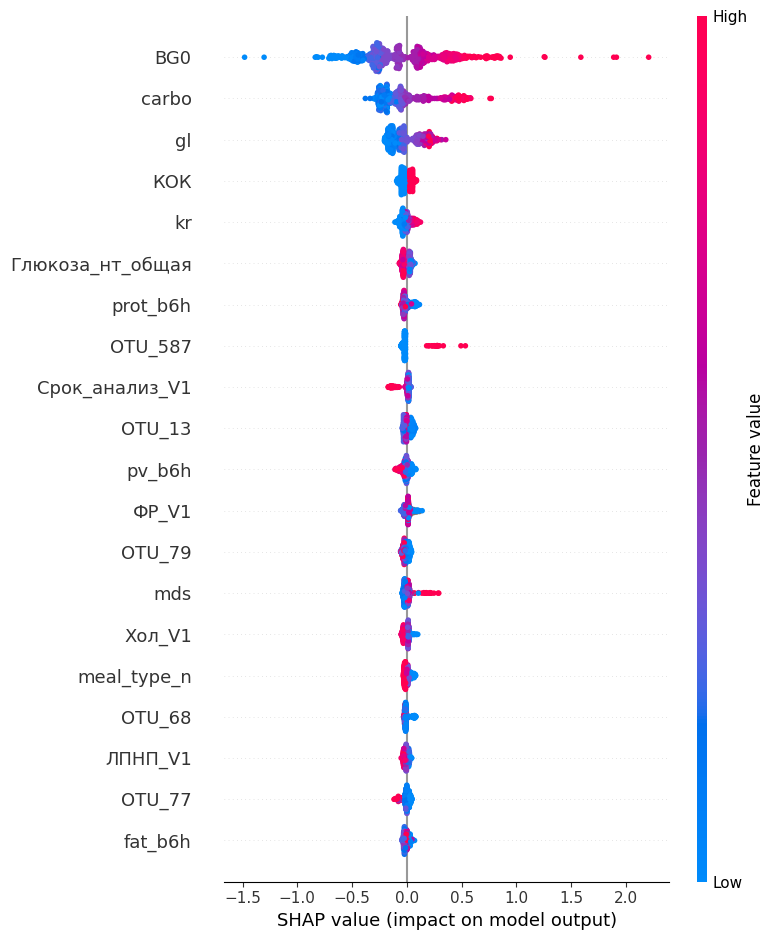

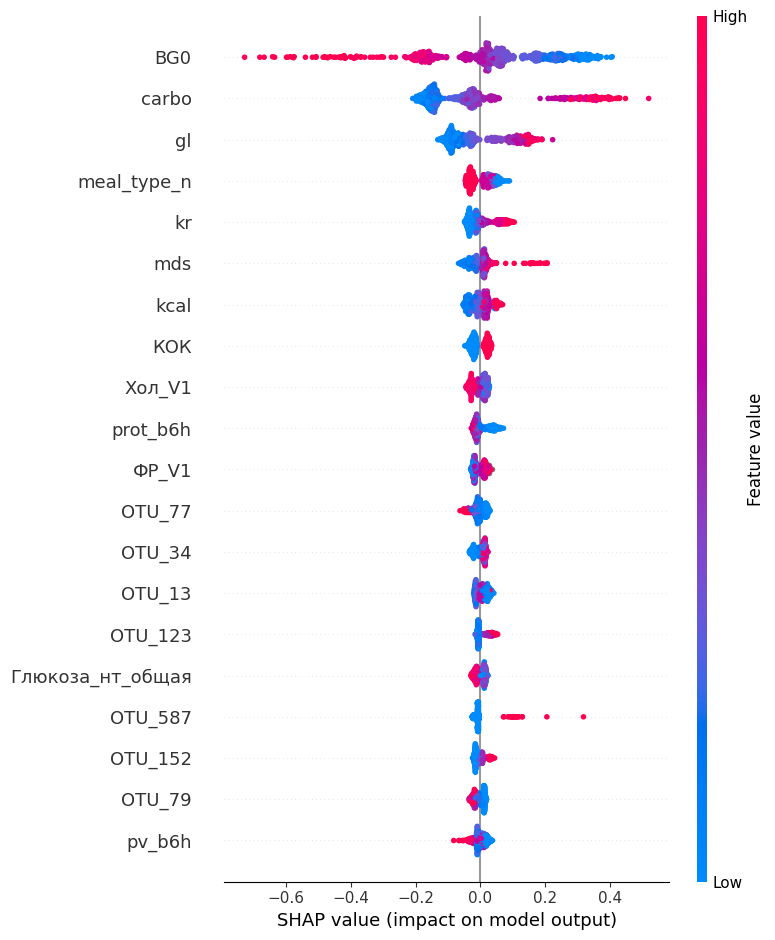

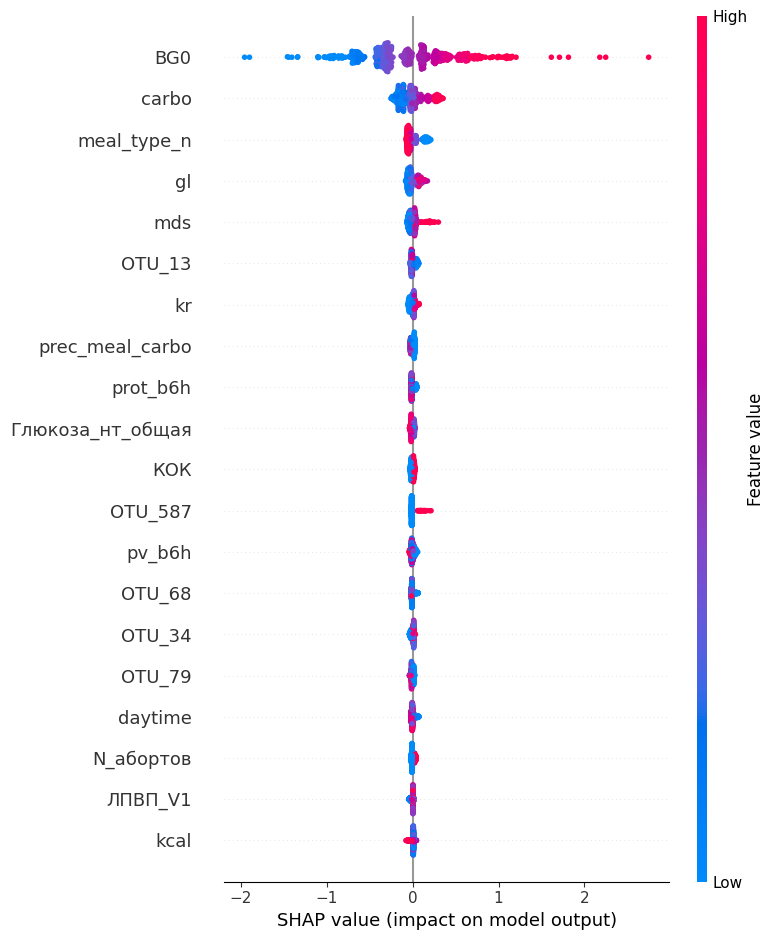

In [69]:
for experiment in history:
    experiment_path = os.path.join(path, experiment)
    os.makedirs(experiment_path, exist_ok=True)
    for target in history[experiment]:
        target_path = os.path.join(experiment_path, target)
        os.makedirs(target_path, exist_ok=True)
        with open(os.path.join(target_path, 'results.txt'), 'w', encoding='UTF-8') as file:
            model_metrics = history[experiment][target]['Metrics']
            file.write(f'{model_metrics}')
            patients_in_experiment = history[experiment][target]['Patients']
            file.write(f'{patients_in_experiment}')
            model_features = history[experiment][target]['Features']
            file.write(f'{model_features}')
            if experiment != 'baseline_model':
                model_params = history[experiment][target]['Model']['parameters']
                file.write(f'{model_params}')
        X_train, y_train = history[experiment][target]['Data']['train']
        X_test, y_test = history[experiment][target]['Data']['test']        
        if experiment != 'baseline_model':        
            estimator = history[experiment][target]['Model']['file']
            estimator.save_model(os.path.join(target_path, 'model.json'))
            shap_values = estimator.predict(xgb.DMatrix(X_test, label=y_test), pred_contribs=True)
            fig = plt.figure()
            shap.summary_plot(shap_values[:,:-1], X_test, feature_names=model_features)
            fig.savefig(os.path.join(target_path, 'shap_summary.png'))
        np.savetxt(os.path.join(target_path, 'X_train.csv'), X_train, delimiter=',', header=','.join(model_features), fmt='%.4f', encoding='UTF-8')
        np.savetxt(os.path.join(target_path, 'y_train.csv'), y_train, delimiter=',', header=target, fmt='%.4f', encoding='UTF-8')
        np.savetxt(os.path.join(target_path, 'X_test.csv'), X_test, delimiter=',', header=','.join(model_features), fmt='%.4f', encoding='UTF-8')
        np.savetxt(os.path.join(target_path, 'y_test.csv'), y_test, delimiter=',', header=target, fmt='%.4f', encoding='UTF-8')

Overall, microbial sequences labeled with the OTU prefix had some effect on glycemia prediction, but the effect was much weaker than that contributed by continuous monitoring data and food intake parameters. Visual analysis of the SHAP plots showed that the model successfully captured the main patterns in the data, in particular the influence of BG0, carbo and gl parameters looked reasonable and consistent. However, more complex patterns remained underrepresented.